In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import readligo as rl

In [114]:
epochs = 200
test_sample_ratio = .2
validation_sample_ratio = 0.1
input_vector_length = 1024
batch_size = 32
num_bins = 40

input_dir = "/Volumes/Research/GWNMMAD_data/Downsampled/V1/"
input_file_list = ["H-H1_GWOSC_O2_4KHZ_R1-1174978560-4096_downsampled", "L-L1_GWOSC_O2_4KHZ_R1-1187291136-4096_downsampled", "V-V1_GWOSC_O2_4KHZ_R1-1187688448-4096_downsampled"]

input_file = input_file_list[1]

output_dir  = "/Volumes/Research/GWNMMAD_data/Model/"

In [104]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1024, 1536),
            nn.LeakyReLU(),
            nn.Linear(1536, 512),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(512, 1536),
            nn.LeakyReLU(),
            nn.Linear(1536, 1024),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [47]:
def normalize(v):
    norm = np.linalg.norm(v)
    junk = 0
    if norm == 0: 
       return v
    return v / norm, junk, norm

In [5]:
def min_max_normalization(v):
    v_flattened = v.flatten()
    coef = max(v_flattened)-min(v_flattened)
    minimal = min(v_flattened)
    v_normalized = (v.copy() - minimal) / coef
    return v_normalized, minimal, coef

In [6]:
def min_max_minus1_normalization(v):
    v_flattened = v.flatten()
    coef = (max(v_flattened)-min(v_flattened)) / 2
    minimal = (max(v_flattened) + min(v_flattened)) / 2
    v_normalized = (v.copy() - minimal) / coef
    return v_normalized, minimal, coef

In [7]:
def normal_distribution_normalization(v):
    v_flattened = v.flatten()
    sigma = np.std(v_flattened)
    mean = v_flattened.mean()
    v_normalized = (v.copy()-mean) / sigma
    return v_normalized, mean, sigma

In [48]:
def bunch_normalization(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    v_set_normalized = np.zeros((v_set.shape[0], v_set.shape[1]))
    for i in range(len(v_set)):
        v_set_normalized[i], recover_min[i], recover_coef[i] = normalize(v_set[i])
    return v_set_normalized, recover_min, recover_coef

In [9]:
def bunch_min_max_normalization(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    v_set_normalized = np.zeros((v_set.shape[0], v_set.shape[1]))
    for i in range(len(v_set)):
        v_set_normalized[i], recover_min[i], recover_coef[i] = min_max_normalization(v_set[i])
    return v_set_normalized, recover_min, recover_coef

In [10]:
def bunch_standardization(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    v_set_normalized = np.zeros((v_set.shape[0], v_set.shape[1]))
    for i in range(len(v_set)):
        v_set_normalized[i], recover_min[i], recover_coef[i] = normal_distribution_normalization(v_set[i])
    return v_set_normalized, recover_min, recover_coef

In [11]:
data = np.load("/Volumes/Research/GWNMMAD_data/Train_Data/LIGO_noise_data_downsampled_whitened_bandpassed.npy").reshape(-1, 1024)
data_for_training_and_testing = data

In [12]:
data_for_training_and_testing = np.load("E://GWNMMAD_data/Train_Data/LIGO_noise_data_downsampled_whitened_bandpassed.npy").reshape(-1, 1024)

FileNotFoundError: [Errno 2] No such file or directory: 'E://GWNMMAD_data/Train_Data/LIGO_noise_data_downsampled_whitened_bandpassed.npy'

In [49]:
total_sample_number = data_for_training_and_testing.shape[0]
test_sample_number = int(test_sample_ratio * total_sample_number)
validation_sample_number = int(validation_sample_ratio * total_sample_number)
train_sample_number = total_sample_number - test_sample_number - validation_sample_number


X_train_ini = data_for_training_and_testing[0:train_sample_number-1].copy()
X_test_ini = data_for_training_and_testing[-test_sample_number:].copy()
X_validation_ini = data_for_training_and_testing[train_sample_number:-test_sample_number-1].copy()

X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_ini)
X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_ini)
X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_normalization(X_validation_ini)

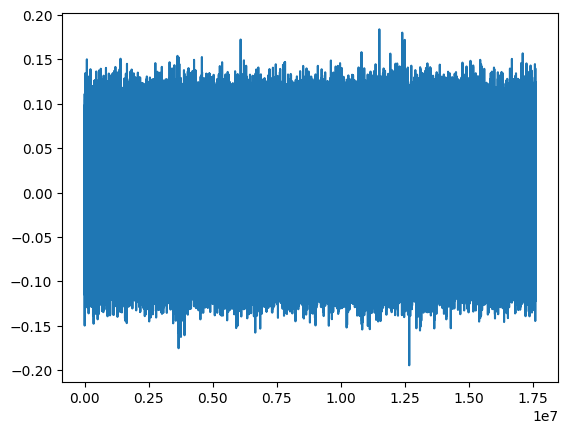

In [15]:
plt.plot(X_train.flatten())

In [50]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

In [105]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = AutoEncoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)
loss_func = nn.MSELoss()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))


for epoch in range(epochs):
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        encoded, decoded = autoencoder(x)
        lossTrain = loss_func(decoded, x)
        optimizer.zero_grad()
        lossTrain.backward()
        optimizer.step()

    # 验证阶段
    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            encoded, decoded = autoencoder(x)
            lossVal = loss_func(decoded, x)
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, lossTrain.item(), val_loss))

Epoch: 0001, Training loss=0.00094810, Validation loss=0.00094700
Epoch: 0002, Training loss=0.00084699, Validation loss=0.00085212
Epoch: 0003, Training loss=0.00077920, Validation loss=0.00079468
Epoch: 0004, Training loss=0.00074452, Validation loss=0.00076985
Epoch: 0005, Training loss=0.00072826, Validation loss=0.00075879
Epoch: 0006, Training loss=0.00071857, Validation loss=0.00075624
Epoch: 0007, Training loss=0.00071778, Validation loss=0.00075677
Epoch: 0008, Training loss=0.00070904, Validation loss=0.00075523
Epoch: 0009, Training loss=0.00070627, Validation loss=0.00075487
Epoch: 0010, Training loss=0.00070532, Validation loss=0.00075466
Epoch: 0011, Training loss=0.00070010, Validation loss=0.00075294
Epoch: 0012, Training loss=0.00069703, Validation loss=0.00075299
Epoch: 0013, Training loss=0.00069670, Validation loss=0.00075176
Epoch: 0014, Training loss=0.00069395, Validation loss=0.00075251
Epoch: 0015, Training loss=0.00069160, Validation loss=0.00075164
Epoch: 001

In [14]:

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))


for epoch in range(epochs):
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        loss = loss_func(decoded, x) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item()))

Epoch: 0001, Training loss=0.01341822
Epoch: 0002, Training loss=0.01104201
Epoch: 0003, Training loss=0.01019036
Epoch: 0004, Training loss=0.01006266
Epoch: 0005, Training loss=0.00998234
Epoch: 0006, Training loss=0.00991805
Epoch: 0007, Training loss=0.00988042
Epoch: 0008, Training loss=0.00971840
Epoch: 0009, Training loss=0.00991736
Epoch: 0010, Training loss=0.00956847
Epoch: 0011, Training loss=0.00953091
Epoch: 0012, Training loss=0.00964568
Epoch: 0013, Training loss=0.00963429
Epoch: 0014, Training loss=0.00956073
Epoch: 0015, Training loss=0.00964599
Epoch: 0016, Training loss=0.00953173
Epoch: 0017, Training loss=0.00942426
Epoch: 0018, Training loss=0.00956501
Epoch: 0019, Training loss=0.00962465
Epoch: 0020, Training loss=0.00949921
Epoch: 0021, Training loss=0.00965156
Epoch: 0022, Training loss=0.00947250
Epoch: 0023, Training loss=0.00955717
Epoch: 0024, Training loss=0.00950609
Epoch: 0025, Training loss=0.00954671
Epoch: 0026, Training loss=0.00952168
Epoch: 0027,

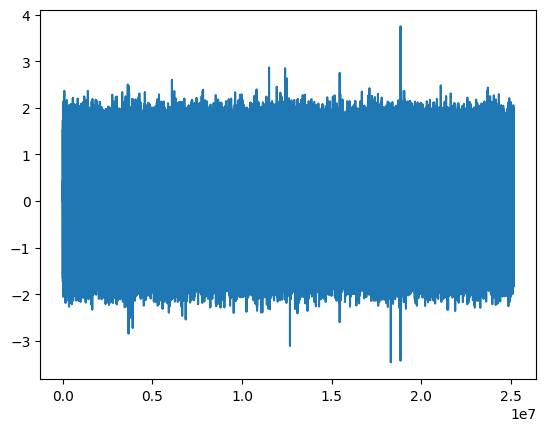

In [22]:
plt.plot(data_for_training_and_testing.flatten())

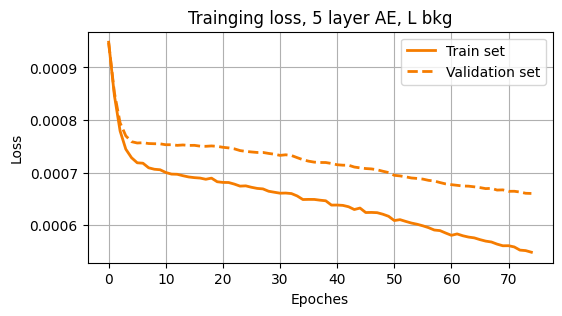

In [106]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 5 layer AE, L bkg')
plt.legend()
plt.show()

In [107]:
_, decodedTestdata = autoencoder(trainData)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean((trainData - reconstructedData)**2,dim=1)
MSE_train = ReconstructedError_train.mean()

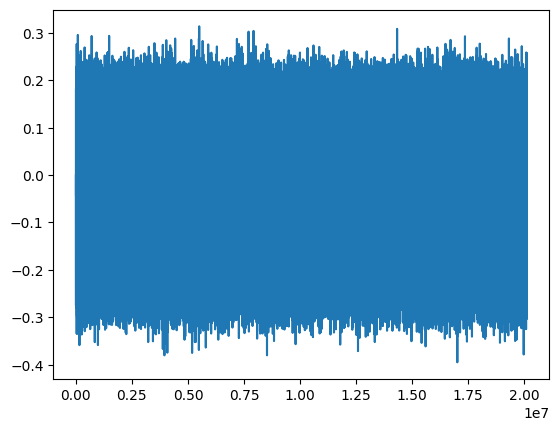

In [78]:
plt.plot(reconstructedData.flatten())

In [52]:
MSE_train

tensor(0.0195, dtype=torch.float64)

Text(0, 0.5, 'Strain')

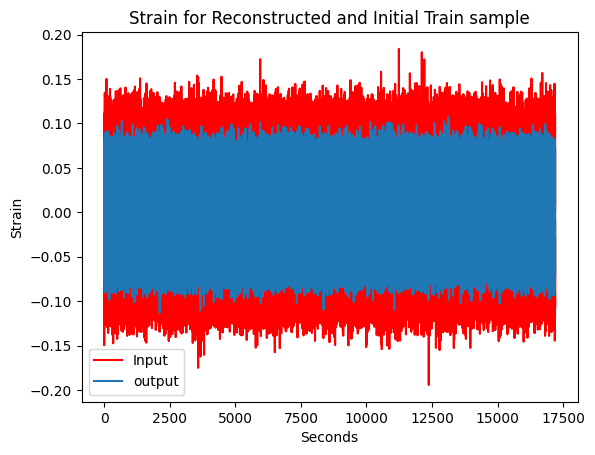

In [108]:
x = np.arange(0, train_sample_number-1, 1/1024)

y = np.zeros((train_sample_number-1, 1024))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData
plt.plot(x, X_train.flatten(), color = 'red', label = 'Input')
plt.plot(x, y.flatten(), label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')

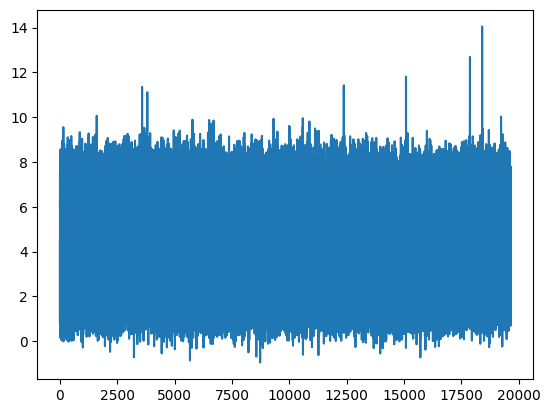

In [32]:
plt.plot(x, y.flatten())

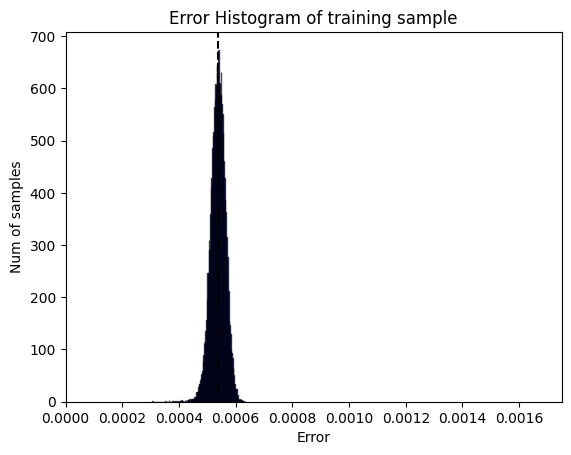

In [109]:
plt.hist(ReconstructedError_train, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample')
plt.xlim(0,0.00175)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_train, color = 'black', linestyle = '--')
plt.show()

In [110]:
_, decodedTestdata = autoencoder(testData)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_test = torch.mean((testData - reconstructedData)**2,dim=1)
MSE_test = ReconstructedError_test.mean()

In [82]:
MSE_test

tensor(0.0378, dtype=torch.float64)

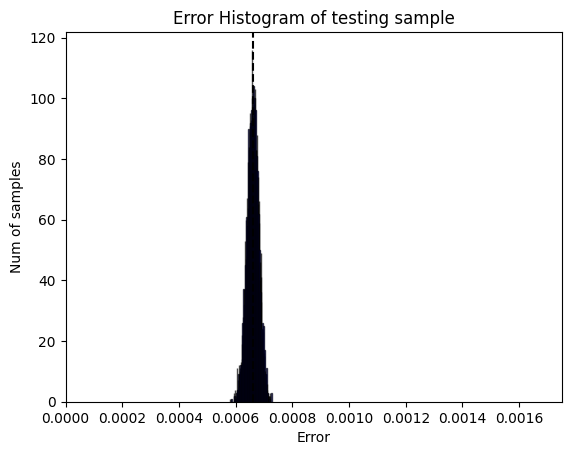

In [111]:
plt.hist(ReconstructedError_test, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of testing sample')
plt.xlim(0,0.00175)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_test, color = 'black', linestyle = '--')
plt.show()

Text(0, 0.5, 'Strain')

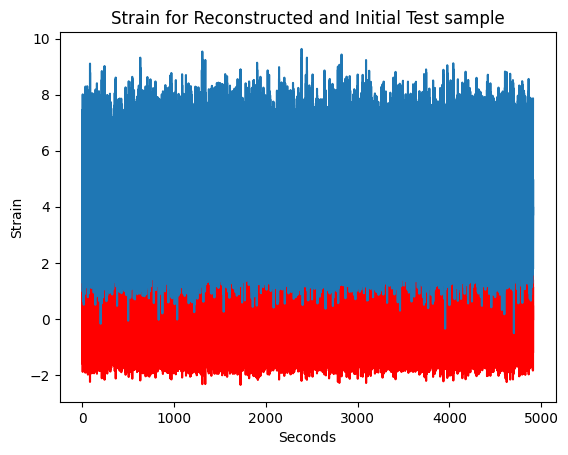

In [39]:
x = np.arange(0, test_sample_number, 1/1024)
plt.plot(x, X_test_ini.flatten(), color = 'red')
y = np.zeros((test_sample_number, 1024))
for i in range(test_sample_number):
    y[i] = 4 * reconstructedData[i] * X_test_recover_coef[i] + X_test_recover_min[i]
plt.plot(x, y.flatten())
plt.title('Strain for Reconstructed and Initial Test sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [61]:
current_time = datetime.datetime.now()
time_string = current_time.strftime("%Y-%m-%d_%H-%M-%S")

output_file_model_name = f"model_{time_string}.pt"
torch.save(autoencoder, "D://Desktop/research/GWNMMAD_data/Model/"+output_file_model_name)

In [28]:
data_injected = np.load("D://Desktop/research/GWNMMAD_data/Train_Data/LIGO_noise_data_downsampled_whitened_bandpassed_test_injected.npy").reshape(-1, 1024)[1798:1802]

FileNotFoundError: [Errno 2] No such file or directory: 'D://Desktop/research/GWNMMAD_data/Train_Data/LIGO_noise_data_downsampled_whitened_bandpassed_test_injected.npy'

In [32]:
data_injected = np.load("/Volumes/Research/GWNMMAD_data/Train_Data/LIGO_noise_data_downsampled_whitened_bandpassed_test_injected.npy").reshape(-1, 1024)

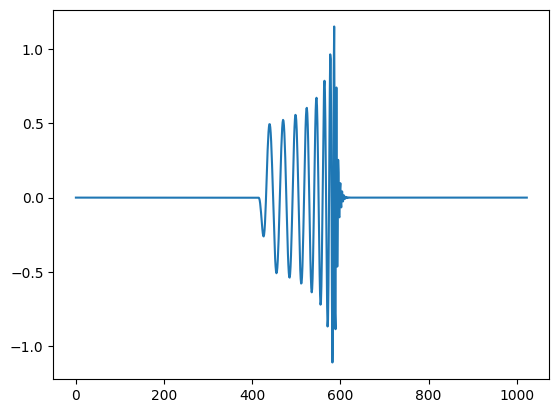

In [35]:
plt.plot(data_injected.flatten())

In [112]:
data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())
data_injected_tensored = torch.FloatTensor(data_injected_normalized)
_, decodedTestdata = autoencoder(data_injected_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_injected = torch.mean((data_injected_tensored - reconstructedData)**2,dim=1)
MSE_injected = ReconstructedError_injected.mean()

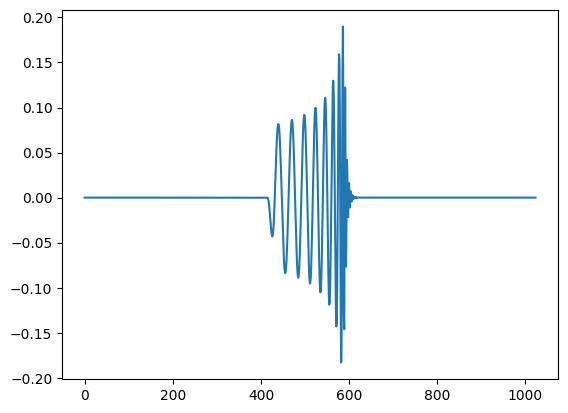

In [45]:
plt.plot(data_injected_normalized.flatten())

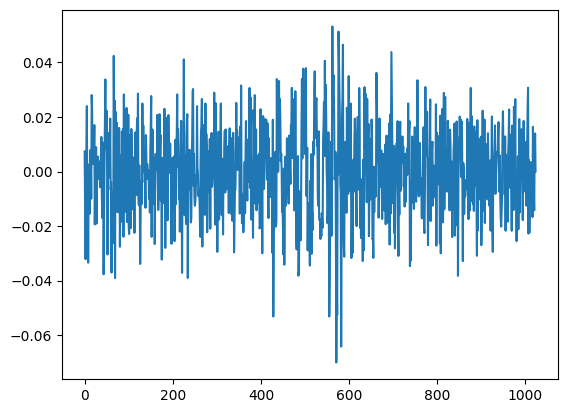

In [75]:
plt.plot(reconstructedData.flatten())

In [113]:
ReconstructedError_injected

tensor([0.0006], dtype=torch.float64)

In [38]:
MSE_injected

tensor(0.0007, dtype=torch.float64)

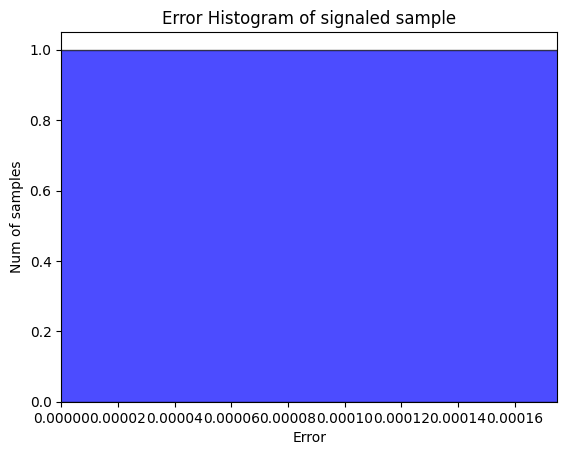

In [40]:
plt.hist(ReconstructedError_injected, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signaled sample')
plt.xlim(0,0.000175)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected, color = 'black', linestyle = '--')
plt.show()

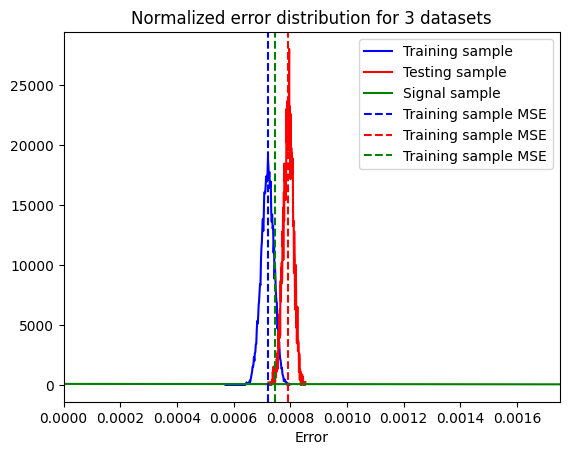

In [44]:
counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = 140, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = 140, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected, bins = 140, density = True)
bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
plt.plot(bin_centers_train, counts_train, color = 'blue', label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = 'red', label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = 'green', label = 'Signal sample')
plt.axvline(x = MSE_train, color = 'blue', linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = 'red', linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_injected, color = 'green', linestyle = '--', label = 'Training sample MSE')
plt.xlim(0, 0.00175)
plt.xlabel('Error')
plt.title('Normalized error distribution for 3 datasets')
plt.legend()
plt.show()